In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import tifffile as tiff
import numpy as np
import os

class RoofDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None): # Initialize the dataset
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.tif')])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = tiff.imread(self.image_paths[idx])
        mask = tiff.imread(self.mask_paths[idx])

        if len(img.shape) == 2:  # Grayscale to RGB
            img = np.stack([img]*3, axis=-1)

        if mask.max() > 1:
            mask = mask // 255

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        return img, mask.long()


In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

# Create dataset and loader

train_dataset = RoofDataset('IMG/AerialImageDataset/train/images', 'IMG/AerialImageDataset/train/gt', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [ ]:
# Model
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
model.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = smp.losses.DiceLoss(mode='binary')


In [ ]:
# Training loop
for epoch in range(10):  # Increase for real training
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1).float()  # Add channel dimension

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.7019
Epoch 2, Loss: 0.6378
Epoch 3, Loss: 0.6190
Epoch 4, Loss: 0.5864
Epoch 5, Loss: 0.5759
Epoch 6, Loss: 0.5469
Epoch 7, Loss: 0.5346
Epoch 8, Loss: 0.5273
Epoch 9, Loss: 0.4974
Epoch 10, Loss: 0.4870


In [ ]:
# Save the model
torch.save(model.state_dict(), "roof_segmentation_model_test_1.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466563..2.6225708].


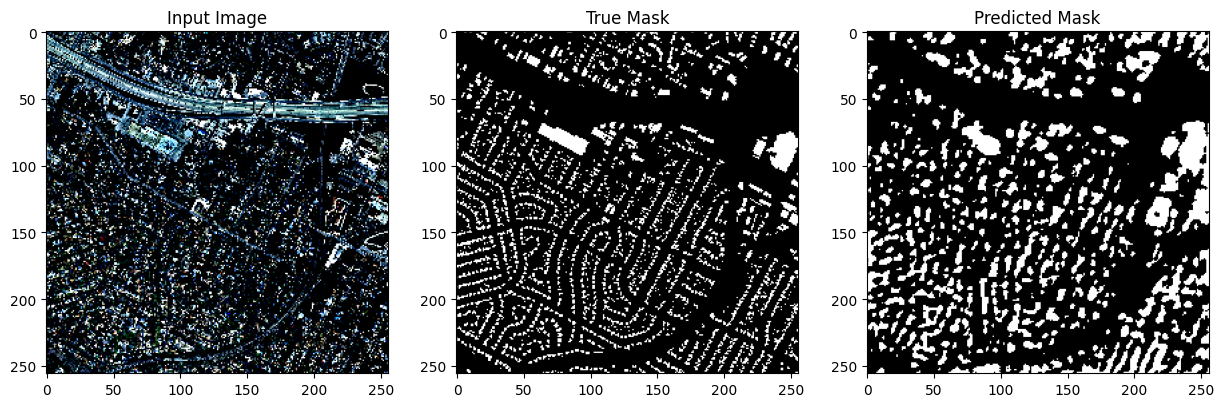

In [23]:
# Put model in eval mode
model.eval()

# Grab one sample from your dataset (or make a test dataset)
test_img, test_mask = train_dataset[0]  # or a separate test_dataset

# Add batch dimension and send to device
input_tensor = test_img.unsqueeze(0).to(device)

# Forward pass (no grad for inference)
with torch.no_grad():
    output = model(input_tensor)

# Output is logits, convert to probabilities with sigmoid
probs = torch.sigmoid(output)[0, 0].cpu().numpy()

# Threshold to get binary mask
pred_mask = (probs > 0.5).astype(int)

# Visualize
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(test_img.permute(1,2,0).cpu())   # input image
axs[0].set_title("Input Image")
axs[1].imshow(test_mask.cpu(), cmap='gray')    # true mask
axs[1].set_title("True Mask")
axs[2].imshow(pred_mask, cmap='gray')          # predicted mask
axs[2].set_title("Predicted Mask")
plt.show()

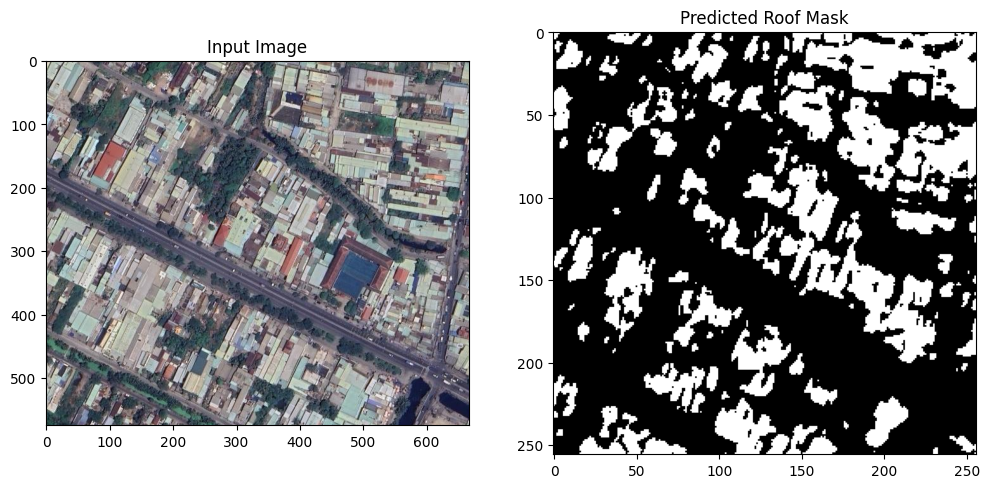

In [33]:
img_path = "test2.tif"  # replace with your image file path
img = tiff.imread(img_path)

# If grayscale, convert to 3 channels
if len(img.shape) == 2:
    img = np.stack([img]*3, axis=-1)

# Transform
transform = A.Compose([
    A.Resize(256, 256),       # same size you used for training
    A.Normalize(),            # same normalization
    ToTensorV2()
])

transformed = transform(image=img)
input_tensor = transformed['image'].unsqueeze(0).to(device)  # add batch dimension & send to device

with torch.no_grad():
    output = model(input_tensor)

probs = torch.sigmoid(output)[0, 0].cpu().numpy()  # probability mask
pred_mask = (probs > 0.5).astype(np.uint8)         # binary mask with threshold 0.5

fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].imshow(img)
axs[0].set_title("Input Image")
axs[1].imshow(pred_mask, cmap='gray')
axs[1].set_title("Predicted Roof Mask")
plt.show()